### Kullanılan kütüphanelerin projeye dahil edilmesi

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Verilen hücre görüntüsünün grayscale olarak yüklenmesi

Görüntü işlemlerine tabi tutmadan önce görüntüyü gri tonlamaları hale getiriyoruz. Böylece tek boyutlu bir görüntü elde etmiş oluyoruz.

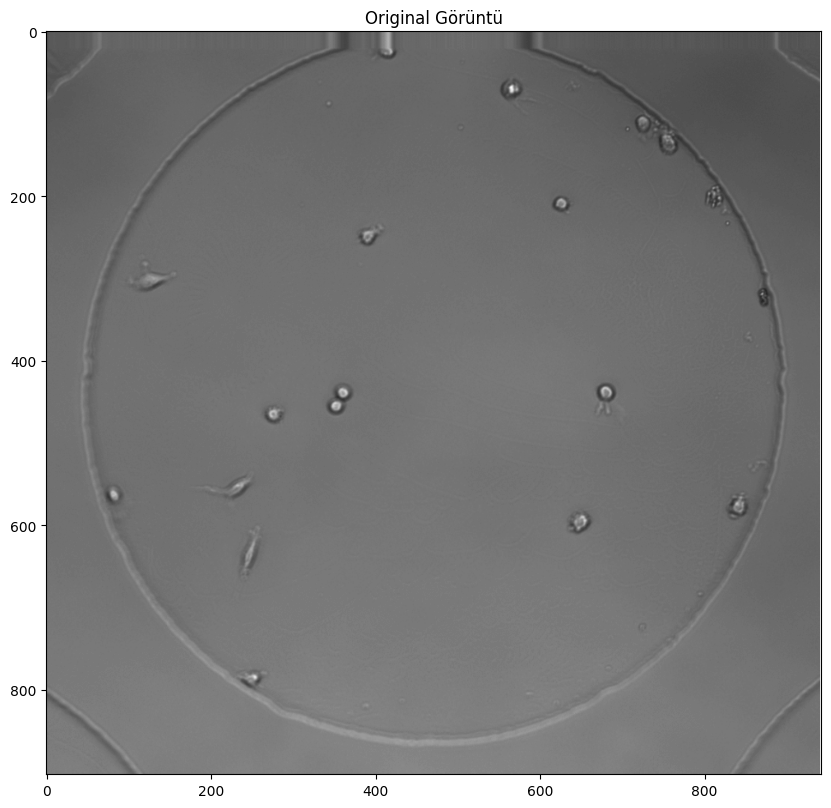

In [2]:
img = cv2.imread("hucre.png")

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1).set_title("Original Görüntü")
plt.imshow(gray_img, cmap="gray")

### Görüntüye keskinleştirme işlemi uygulanması


cv2.filter2D fonksiyonu ile görüntüyü keskinleştirmeye çalıştım. Ama daha başarılı sonucu önce GaussianBlur ile yumuşatma işlemi yapıp üstüne orjinal görüntüyü eklemek ile buldum. 9X9 boyutlu bir kernel kullandım.

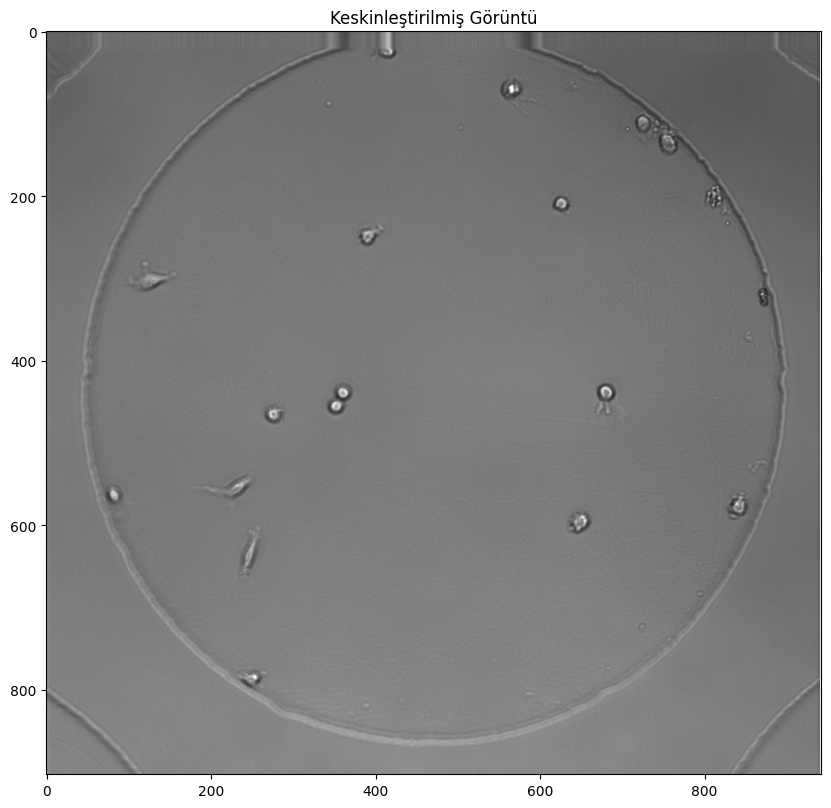

In [3]:
gaussian_blur = cv2.GaussianBlur(gray_img, (9, 9), 10)
sharpened_img = cv2.addWeighted(gray_img, 1.5, gaussian_blur, -0.5, 0)

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1).set_title("Keskinleştirilmiş Görüntü")
plt.imshow(sharpened_img, cmap="gray")

### Keskinleştirilmiş görüntüye eşikleme yöntemi ile ikili görüntüye dönüştürme

Keskinleştirme (thresholding), görüntüde belirli bir eşik değeri kullanarak pikselleri siyah ve beyaz olarak ikiye böler.
threshold_local ve threshold_otsu ile denemeler yaptım. En başarılı sonucu adaptiveThreshold ile sağladım.

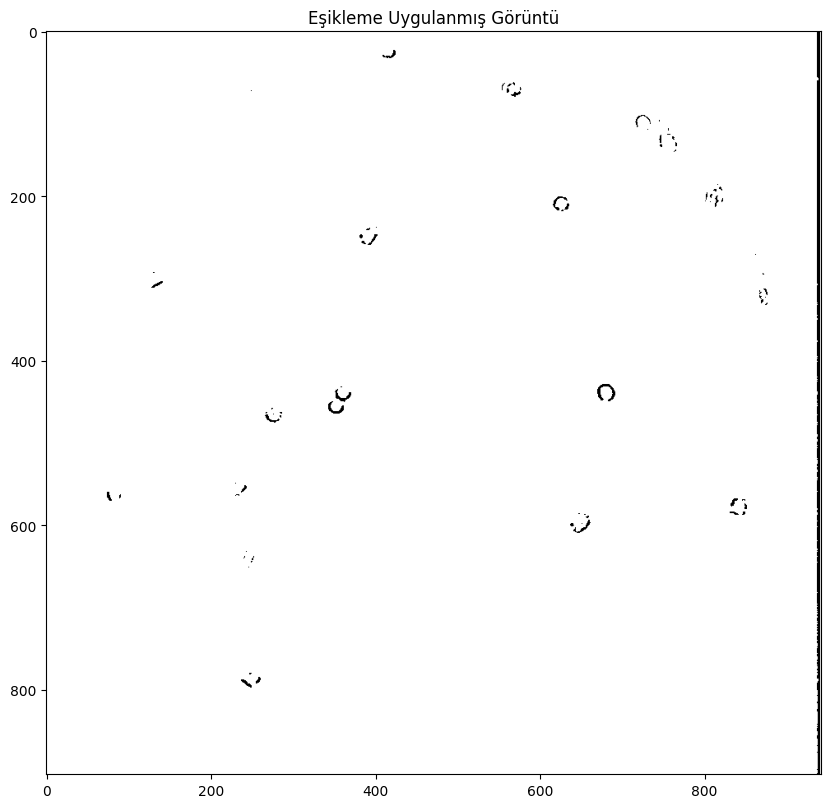

In [4]:
thresh_img = cv2.adaptiveThreshold(sharpened_img, 155, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 23, 29)

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1).set_title("Eşikleme Uygulanmış Görüntü")
plt.imshow(thresh_img, cmap="gray")

### Görüntüye morfolojik bir teknik uygulama

Çıktı çok sayıda bileşen içerdiği için, bileşen sayısını azaltmak için morfolojik bir teknik uygulamak gerekti.
Özellikle görüntüdeki küçük nesnelerin veya gürültülerin kaldırılmasında ve nesnelerin kenarlarının yumuşatılmasında için 1X1 bir kernel ile açma işlemi(Opening) uyguladım.

Elde ettiğim görüntüye nesnelerin kenarlarını aşındırıp küçültmesi için erozyon(erosion) uyguladım. Erozyon, nesne kenarlarındaki ince uzantıları kaldırarak nesneleri küçültür. Erozyonda 2X2'lik bir kerneli tek iterasyon ile kullandım.

Kenar tespiti (Edge detection) işlemi, bir görüntüdeki nesne sınırlarını veya kenarlarını belirleme işlemidir. Bu çalışmada en başarılı kenar tespit algoritmalarından biri olan Canny'yi kullandım. Bir sonraki aşamada bağlantılı bileşenlerin tespiti için Canny'yi kullanmak önem arz etmektedir.

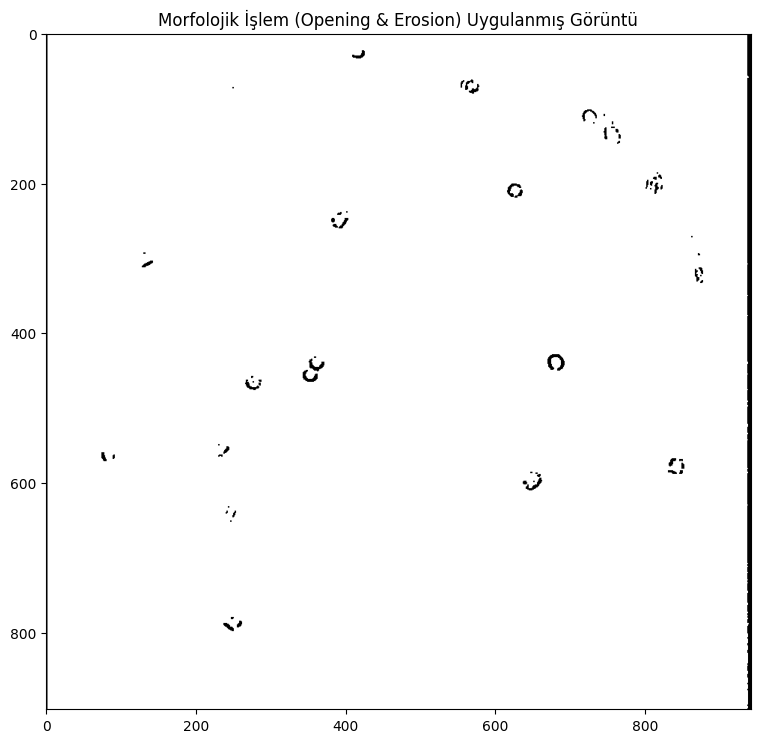

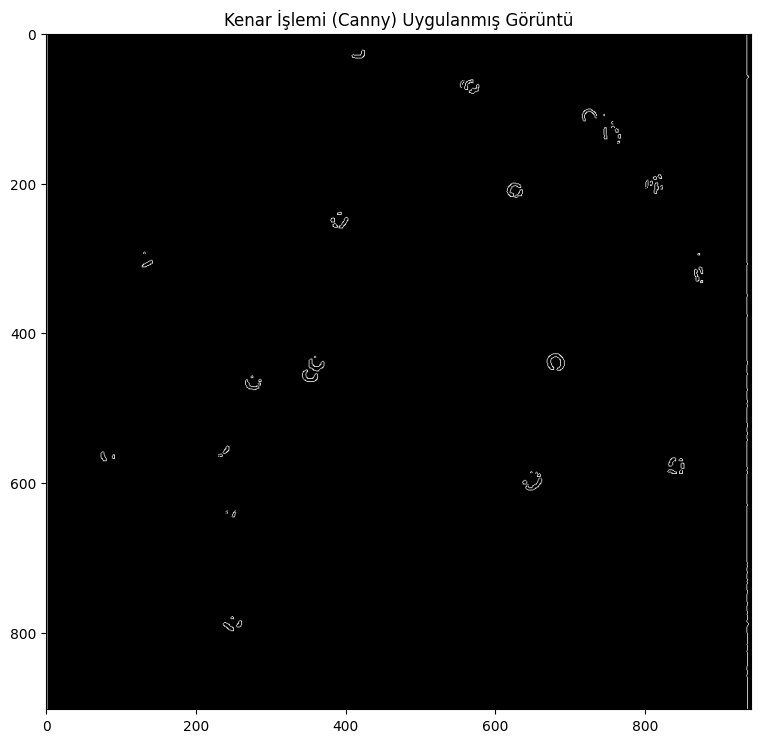

In [5]:
kernel_opening = np.ones((1, 1), np.uint8)
opening_result = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel_opening)

kernel_erosion = np.ones((2, 2), np.uint8)
erosion_img = cv2.erode(opening_result, kernel_erosion, iterations=1)
edge_img = cv2.Canny(erosion_img, 100, 200)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1).set_title("Morfolojik İşlem (Opening & Erosion) Uygulanmış Görüntü")
plt.imshow(erosion_img, cmap="gray")

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 2).set_title("Kenar İşlemi (Canny) Uygulanmış Görüntü")
plt.imshow(edge_img, cmap="gray")

### Genişletme işleminin uygulanması

Bağlantı bileşenlerini etiketlemeden önce son bir morfolojik işlem olan genişletme (dilation) işlemini uyguladım. Bu işlem nesneleri genişleterek bağlantı bileşenlerinin tespitine kolaylık sağlayacaktır. 4X4'lik bir kernel ile 2 iterasyon kullandım.

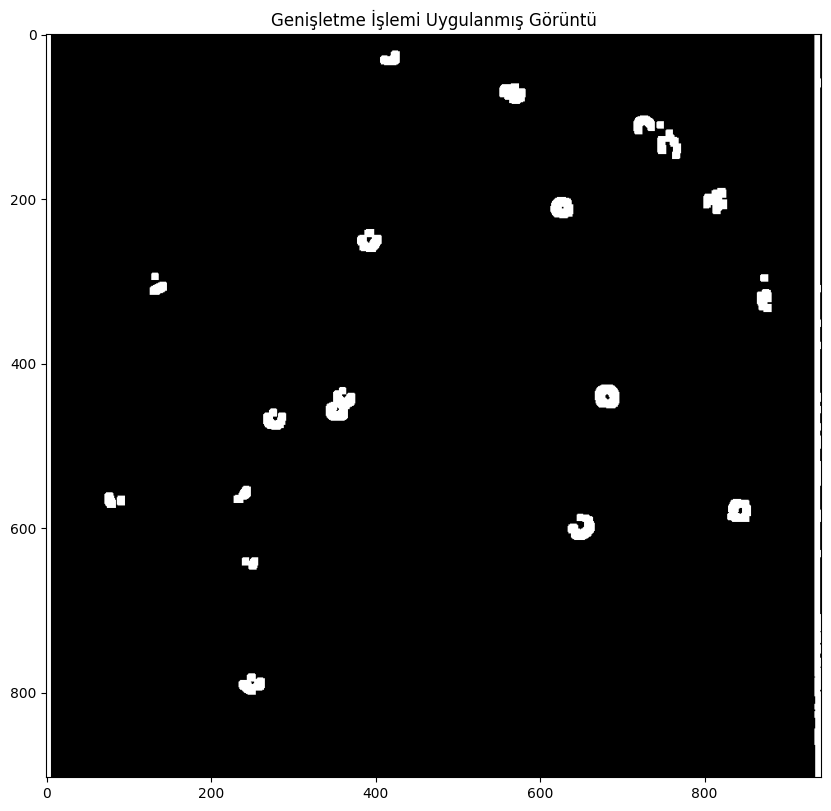

In [6]:
kernel = np.ones((4,4), np.uint8)
dilated_edges = cv2.dilate(edge_img, kernel, iterations=2)

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1).set_title("Genişletme İşlemi Uygulanmış Görüntü")
plt.imshow(dilated_edges, cmap="gray")

### Bağlantı bileşen etiketleme algoritmasını uygulama

Bağlantı bileşenleri etiketleme (connected components labeling) işleminin temel amacı, bir görüntüdeki farklı nesneleri, nesnelerin piksellerini ayrı gruplara ayırarak etiketlemektir. Bileşenlerin yönü, alanı vb. bilgilerini bulmak için connectedComponentsWithStats fonksiyonunu kullandım. Bu fonksiyon istatistiki bilgileri de döner.

In [7]:
_, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated_edges)

### Algılanan bileşenleri farklı renklerde gösterme

Genişletme uygulanmış görseldeki bileşenleri farklı renklerde göstermek için öncelikle resmi gri seviyeden renkli seviyeye getirdim.
applyColorMap ile önceki aşamada bulunan etiketlere renklendirme uyguladım.

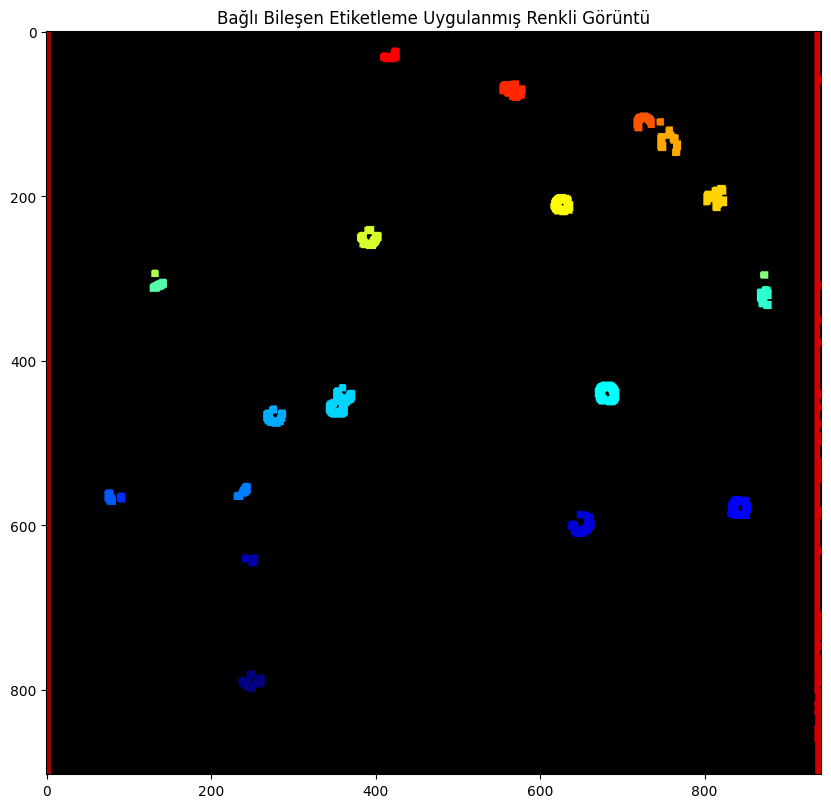

In [8]:
colored_img = cv2.cvtColor(dilated_edges, cv2.COLOR_BGR2RGB)

color_map = cv2.applyColorMap(np.uint8(labels * 255 / labels.max()), cv2.COLORMAP_JET)

result_img = np.zeros_like(colored_img)

for label in range(1, len(stats)):
    mask = (labels == label)
    color = np.random.randint(0, 256, size=3)
    result_img[mask] = color_map[mask]

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1).set_title("Bağlı Bileşen Etiketleme Uygulanmış Renkli Görüntü")
plt.imshow(result_img)

### Tespit edilen nesneler için istatistiki bilgilerin bulunması

connectedComponentsWithStats ile bulunan nesne istatistikleri içinde dönerek alanı, yönü, daireselliği, alanın çevreye oranı ve kompaktlığı ekrana yazdırdım.

In [9]:
for i in range(1, len(stats)):    
    area = stats[i][cv2.CC_STAT_AREA] # Alanı hesapla

    x, y, width, height = stats[i][cv2.CC_STAT_LEFT:cv2.CC_STAT_LEFT+4]
    direction = (width, height) # Yönü

    perimeter = 2 * (width + height) # Çevresi

    circularity = (4 * 3.1415 * area) / (perimeter ** 2) # Dairesellik
 
    region_mask = (labels == i).astype(np.uint8)
    
    contours, _ = cv2.findContours(region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Kontur bulma işlemi
    contour_of_interest = contours[0]

    perimeter_of_interest = cv2.arcLength(contour_of_interest, True)
    area_of_interest = stats[i][cv2.CC_STAT_AREA]
    area_to_perimeter_ratio = area_of_interest / perimeter_of_interest

    compactness = (4 * 3.1415 * area_of_interest) / (perimeter_of_interest ** 2) # Kompaktlığı hesaplama

    print(f"{str(i).rjust(2, '0')}. bölge için alanı: {area}\t yönü: {direction}\t daireselliği: {round(circularity, 4)}\t alanın çevreye oranı: {round(area_to_perimeter_ratio, 4)}\t kompaktlığı : {round(compactness, 4)}")

01. bölge için alanı: 5418	 yönü: (6, 903)	 daireselliği: 0.0206	 alanın çevreye oranı: 2.9868	 kompaktlığı : 0.0207
02. bölge için alanı: 6581	 yönü: (8, 903)	 daireselliği: 0.0249	 alanın çevreye oranı: 3.5895	 kompaktlığı : 0.0246
03. bölge için alanı: 329	 yönü: (24, 18)	 daireselliği: 0.5859	 alanın çevreye oranı: 4.4229	 kompaktlığı : 0.7472
04. bölge için alanı: 626	 yönü: (32, 25)	 daireselliği: 0.6053	 alanın çevreye oranı: 6.185	 kompaktlığı : 0.7679
05. bölge için alanı: 449	 yönü: (26, 23)	 daireselliği: 0.5875	 alanın çevreye oranı: 4.6633	 kompaktlığı : 0.6086
06. bölge için alanı: 79	 yönü: (9, 9)	 daireselliği: 0.766	 alanın çevreye oranı: 2.5626	 kompaktlığı : 1.0445
07. bölge için alanı: 633	 yönü: (29, 36)	 daireselliği: 0.4707	 alanın çevreye oranı: 4.2188	 kompaktlığı : 0.3533
08. bölge için alanı: 679	 yönü: (29, 32)	 daireselliği: 0.5733	 alanın çevreye oranı: 5.3375	 kompaktlığı : 0.5272
09. bölge için alanı: 615	 yönü: (28, 26)	 daireselliği: 0.6626	 alanın çev